In [7]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd
import numpy as np

# Keras import
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import get_file
#from tensorflow.python.ops.math_ops import reduce_prod
import numpy as np
import pandas as pd
import random
import sys
import io
import requests
import re
###########################################################

np.random.seed(42)
pd.set_option('display.max_rows', 1000)
pd.set_option( 'display.max_colwidth', None )

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.4.0
Keras Version: 2.4.0

Python 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) 
[GCC 9.4.0]
Pandas 1.3.3
Scikit-Learn 1.0
GPU is NOT AVAILABLE


2022-01-22 20:02:12.675512: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


# Lesson goal
* Understand the architecture of the vanilla LSTM
* From memory copy Jeff Heaton's show case of the LSTM.


In this particular problem, I want to simulate a car travelling down a road, and it has 1 of 3 colors. Sometimes it will be caught in the first frame, sometimes in the second. Sometimes the car is long. I just want the color returned

In [293]:
# I need a general function that, given a list and 
# what categories I expect, generate a one-hot encoding.
def make_dummies(sequence, categories=None):
    # Given a list "sequence" return it one-hot encoded
    # This automatically finds all the unique values in
    # the input and makes them the categories. Requires
    # numpy and pandas as imports
    if not categories:
        categories = set(np.array(sequence).flatten())
    sequence = pd.DataFrame(sequence, 
                            dtype=pd.CategoricalDtype(categories=categories))
    sequence = pd.get_dummies(sequence)
    return np.array(sequence)

In [294]:
#make_dummies(mock_dataset)

mock_dataset = [[0,0,1,1,0],
                [0,1,1,1,0],
                [2,0,0,0,0],
                [0,0,0,2,2],
                [0,0,3,3,0],
                [2,2,0,0,0],
                [0,0,0,2,2],
                [3,3,0,0,0],
                [2,2,2,0,0],
                [0,0,1,0,0]
               ]
make_dummies([1,5,6])

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

In [ ]:
# Making the dataset
colors = [1,2,3]
mock_dataset = [[0,0,1,1,0],
                [0,1,1,1,0],
                [2,0,0,0,0],
                [0,0,0,2,2],
                [0,0,3,3,0],
                [2,2,0,0,0],
                [0,0,0,2,2],
                [3,3,0,0,0],
                [2,2,2,0,0],
                [0,0,1,0,0]
               ]

mock_dataset = pd.DataFrame(mock_dataset,
                           dtype=pd.CategoricalDtype(categories=[0,1,2,3]))
mock_dataset = pd.get_dummies(mock_dataset, prefix='timestep')
mock_dataset = np.array(mock_dataset).reshape(10, 5, 4)

# Making the "answer key"
mock_y = pd.DataFrame([1,1,2,2,3,2,2,3,2,1],
                      columns=['color'],
                     dtype=pd.CategoricalDtype(categories=colors))

mock_y = pd.get_dummies(mock_y,prefix='color')


In [268]:
# Wow this is super simple to implement
model = Sequential()
model.add(LSTM(20, input_shape=(5,4)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam')

In [269]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 20)                2000      
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 63        
Total params: 2,063
Trainable params: 2,063
Non-trainable params: 0
_________________________________________________________________


In [273]:
hist = model.fit(mock_dataset, mock_y, 
                 epochs=70, verbose=0,
                 batch_size=3)

In [274]:
hist.history['loss'][-1]

0.06033936142921448

In [266]:
new_input = [0,0,0,0,2]
new_input = np.array(pd.get_dummies(pd.Series(new_input, dtype=pd.CategoricalDtype(categories=[0,1,2,3])))).reshape(1,5,4)
yhat = model.predict(new_input)
yhat

array([[0.29320315, 0.6144356 , 0.09236125]], dtype=float32)

In [267]:
colors[np.argmax(yhat)]

2

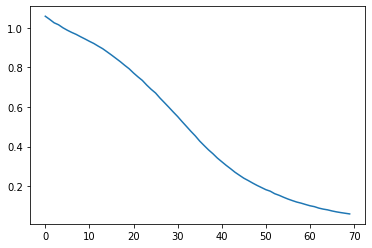

In [276]:
plt.plot(hist.history['loss'])